In [4]:
import os
import numpy as np
from PIL import Image
import copy
from sklearn.model_selection import train_test_split

Load Dataset

In [5]:
def load_data(root, reduce=4):
    """ 
    Load ORL (or Extended YaleB) dataset to numpy array.
    
    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
        
    """ 
    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):
        
        if not os.path.isdir(os.path.join(root, person)):
            continue
        
        for fname in os.listdir(os.path.join(root, person)):    
            
            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue
            
            if not fname.endswith('.pgm'):
                continue
                
            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            
            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

In [6]:
X, Y = load_data(root='data/ORL', reduce=3)
print('ORL dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))
print(X.size)

# Load Extended YaleB dataset.
X, Y = load_data(root='data/CroppedYaleB', reduce=4)
print('Extended YalB dataset: X.shape = {}, Y.shape = {}'.format(X.shape, Y.shape))

ORL dataset: X.shape = (1110, 400), Y.shape = (400,)
444000
Extended YalB dataset: X.shape = (2016, 2414), Y.shape = (2414,)


block-occlusion noise

In [7]:
def add_noise (X,p=0.2):
    X_noised=copy.deepcopy(X)
    for i in range (X.shape[1]):
        idx=np.random.choice(X.shape[0],int(X.shape[0]*p),replace=False)
        X_noised[idx,i]=255
    return X_noised

L21NMF

In [8]:
class L21_NMF():
    def __init__(self,n_components=100,max_iter=100,eps=1e-5,print_output=False):
        self.n_components=n_components
        self.max_iter=max_iter
        self.eps=eps
        self.print_output=print_output
        self.W=None
        self.H=None
        
    def fit(self,X):
        self.W=np.random.random((X.shape[0],self.n_components))
        self.H=np.random.random((self.n_components,X.shape[1]))
        
        for iter in range(self.max_iter):
            D=np.diag(1/np.sqrt(np.sum(((X-self.W.dot(self.H))**2),axis=0)))
            W_new=self.W*((X.dot(D).dot(self.H.T))/(self.W.dot(self.H).dot(D).dot(self.H.T)))
            H_new=self.H*((W_new.T.dot(X).dot(D))/(W_new.T.dot(W_new).dot(self.H).dot(D)))
            
            difference=np.linalg.norm(self.H-H_new)+np.linalg.norm(self.W-W_new)
            
            self.W=W_new
            self.H=H_new
            
            if difference<=self.eps:
                print("End")
                return self.W,self.H
            
            loss=np.sum(np.sqrt(np.sum((X-self.W.dot(self.H))**2,axis=0)))
            
            if self.print_output:
                if i % 50==0:
                    print("Current iteration: %s(%s%%)/tloss: %.2f" % (i,int((i/self.max_iter)*100),loss))
                    
        return self.W, self.H

Evalution

In [9]:
def RRE (X,W,H):
    return  np.linalg.norm(X- W.dot(H)) / np.linalg.norm(X)

from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

def assign_cluster_label(X, Y):
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

ORL dataset

In [10]:
from sklearn.model_selection import train_test_split
rre_list=[]
acc_list=[]
nmi_list=[]

for i in range (5):
    # Load dataset.
    print('==> Load ORL dataset ...')
    X,Y = load_data('data/ORL', reduce=3)
    V_hat, _,Y_hat,_=train_test_split(X.T,Y,test_size=0.1)
    V_hat=V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

    # Add Noise.
    print('==> Add noise...')
    V_noise = add_noise(V_hat,p=0.1) 
    
    
    print('==> Apply L21_NMF ...')
    model = L21_NMF(n_components=len(set(Y_hat)),max_iter=1000,eps=1e-3,print_output=True) # set n_components to num_classes.
    W,H = model.fit(V_noise)
    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))
    
    
    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE ...')
    rre = RRE(V_hat,W,H)
    rre_list.append(rre)
    print('RRE = {:.4f}'.format(rre))
   

    print('==> Evaluate Acc and NMI ...')
    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    print("***********************************************************\n\n")
    

print("Mean RRE=%.4f\tMean Accuracy=%.4f \tMean NMI=%.4f" % (np.mean(rre_list),np.mean(acc_list),np.mean(nmi_list)))
print("Std RRE=%.4f\tStd Accuracy=%.4f \tStd NMI=%.4f" % (np.std(rre_list),np.std(acc_list),np.std(nmi_list)))

==> Load ORL dataset ...
V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise...
==> Apply L21_NMF ...
Current iteration: 0(0%)/tloss: 658874.96
Current iteration: 0(0%)/tloss: 657754.41
Current iteration: 0(0%)/tloss: 656929.95
Current iteration: 0(0%)/tloss: 656127.39
Current iteration: 0(0%)/tloss: 655339.73
Current iteration: 0(0%)/tloss: 654560.63
Current iteration: 0(0%)/tloss: 653783.85
Current iteration: 0(0%)/tloss: 653003.09
Current iteration: 0(0%)/tloss: 652211.83
Current iteration: 0(0%)/tloss: 651403.26
Current iteration: 0(0%)/tloss: 650570.19
Current iteration: 0(0%)/tloss: 649704.93
Current iteration: 0(0%)/tloss: 648799.24
Current iteration: 0(0%)/tloss: 647844.36
Current iteration: 0(0%)/tloss: 646831.02
Current iteration: 0(0%)/tloss: 645749.54
Current iteration: 0(0%)/tloss: 644590.10
Current iteration: 0(0%)/tloss: 643343.03
Current iteration: 0(0%)/tloss: 641999.34
Current iteration: 0(0%)/tloss: 640551.36
Current iteration: 0(0%)/tloss: 638993.53
Current it

V_hat.shape=(1110, 360), Y_hat.shape=(360,)
==> Add noise...


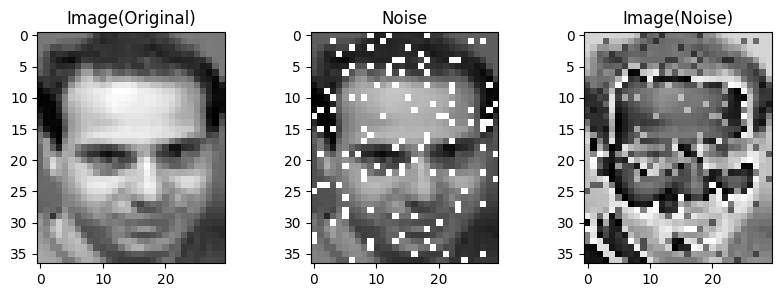

In [11]:
X,Y = load_data('data/ORL', reduce=3)
V_hat, _,Y_hat,_=train_test_split(X.T,Y,test_size=0.1)
V_hat=V_hat.T
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

 # Add Noise.
print('==> Add noise...')
V_noise = add_noise(V_hat,p=0.1) 
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//3 for i in (92, 112)] # ORL
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()

Yale B dataset

In [12]:
rre_list=[]
acc_list=[]
nmi_list=[]

for i in range (5):
    # Load dataset.
    print('==> Load ORL dataset ...')
    X,Y = load_data('data/CroppedYaleB', reduce=4)
    V_hat, _,Y_hat,_=train_test_split(X.T,Y,test_size=0.1)
    V_hat=V_hat.T
    print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

    # Add Noise.
    print('==> Add noise...')
    V_noise = add_noise(V_hat,p=0.1) 
    
    
    print('==> Apply L21_NMF ...')
    model = L21_NMF(n_components=len(set(Y_hat)),max_iter=1000,eps=1e-3,print_output=True) # set n_components to num_classes.
    W,H = model.fit(V_noise)
    print('W.shape={}, H.shape={}'.format(W.shape, H.shape))
    
    
    # Evaluate relative reconstruction errors.
    print('==> Evaluate RRE ...')
    rre = RRE(V_hat,W,H)
    rre_list.append(rre)
    print('RRE = {:.4f}'.format(rre))
   

    print('==> Evaluate Acc and NMI ...')
    # Assign cluster labels.
    Y_pred = assign_cluster_label(H.T, Y_hat)
    acc = accuracy_score(Y_hat, Y_pred)
    acc_list.append(acc)
    nmi = normalized_mutual_info_score(Y_hat, Y_pred)
    nmi_list.append(nmi)
    print('Acc(NMI) = {:.4f} ({:.4f})'.format(acc, nmi))
    print("***********************************************************\n\n")
    

print("Mean RRE=%.4f\tMean Accuracy=%.4f \tMean NMI=%.4f" % (np.mean(rre_list),np.mean(acc_list),np.mean(nmi_list)))
print("Std RRE=%.4f\tStd Accuracy=%.4f \tStd NMI=%.4f" % (np.std(rre_list),np.std(acc_list),np.std(nmi_list)))


==> Load ORL dataset ...
V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise...
==> Apply L21_NMF ...
Current iteration: 0(0%)/tloss: 7130369.87
Current iteration: 0(0%)/tloss: 7096097.76
Current iteration: 0(0%)/tloss: 7092913.37
Current iteration: 0(0%)/tloss: 7089063.82
Current iteration: 0(0%)/tloss: 7083787.51
Current iteration: 0(0%)/tloss: 7075915.07
Current iteration: 0(0%)/tloss: 7063445.30
Current iteration: 0(0%)/tloss: 7043074.27
Current iteration: 0(0%)/tloss: 7009745.57
Current iteration: 0(0%)/tloss: 6956854.88
Current iteration: 0(0%)/tloss: 6878588.04
Current iteration: 0(0%)/tloss: 6775742.81
Current iteration: 0(0%)/tloss: 6661501.97
Current iteration: 0(0%)/tloss: 6556846.45
Current iteration: 0(0%)/tloss: 6475825.31
Current iteration: 0(0%)/tloss: 6419015.98
Current iteration: 0(0%)/tloss: 6379861.34
Current iteration: 0(0%)/tloss: 6351603.42
Current iteration: 0(0%)/tloss: 6329593.98
Current iteration: 0(0%)/tloss: 6311096.47
Current iteration: 0(0%)/tloss

V_hat.shape=(2016, 2172), Y_hat.shape=(2172,)
==> Add noise...


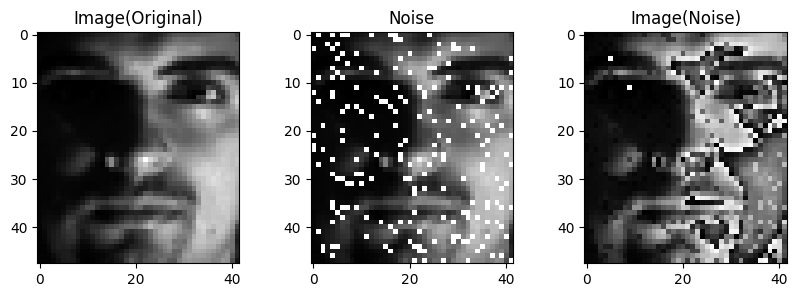

In [13]:
X,Y = load_data('data/CroppedYaleB', reduce=4)
V_hat, _,Y_hat,_=train_test_split(X.T,Y,test_size=0.1)
V_hat=V_hat.T
print('V_hat.shape={}, Y_hat.shape={}'.format(V_hat.shape, Y_hat.shape))

 # Add Noise.
print('==> Add noise...')
V_noise = add_noise(V_hat,p=0.1) 
V = V_hat + V_noise

# Plot result.
import matplotlib.pyplot as plt
img_size = [i//4 for i in (168, 192)] # Yale B
ind = 2 # index of demo image.
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(V_hat[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Original)')
plt.subplot(132)
plt.imshow(V_noise[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Noise')
plt.subplot(133)
plt.imshow(V[:,ind].reshape(img_size[1],img_size[0]), cmap=plt.cm.gray)
plt.title('Image(Noise)')
plt.show()